## Midcap Stocks
Follow along the code to do the preliminary data analysis!\
**Please refer to the [meeting notes here](https://docs.google.com/document/d/1tnDnYfO5m5GQz5Fm7_TbpzHN9bG3RmvqpgvL4TyOevI/edit?usp=sharing) to get familiar with all the column names and the values associated with them.**

### Step 1: Install the necessary libraries for our data collection.
[yfinance](https://python-yahoofinance.readthedocs.io/en/latest/): used to fetch historical stock data (price, volume, etc.) from Yahoo Finance for our assigned sectors.\
[ta](https://technical-analysis-library-in-python.readthedocs.io/en/latest/): used to calculate technical indicators from the price data we get with yfinance. These indicators help our model understand:
- Trends (e.g., SMA, EMA, MACD)
- Momentum (e.g., RSI)
- Volatility (e.g., ATR, Bollinger Bands)
- Volume pressure (e.g., OBV)

In [7]:
!pip install yfinance
!pip install ta

### Step 2: Import the necessary libraries

In [2]:
import yfinance as yf
import pandas as pd
import time
import ta

### Step 3: Collect Preliminary Stock Data Using `yfinance`

In this step, you will collect **5 years of historical daily stock data** for your assigned sector using the `yfinance` library.

**What this code does:**
- Loops through a list of stock tickers.
- Uses `yfinance` to download daily data for each stock over a 5-year period.
- Waits 3 seconds between requests to avoid hitting API limits.
- Cleans and formats the data: resets the index and adds a "Ticker" column.
- Stores all the data in one master DataFrame called `price_df`.

**What you need to do:**
- Replace the `tickers` list with the stocks **assigned to your sector**.
- You can find your list of stocks by referring to the excel file we created earlier [here](https://docs.google.com/spreadsheets/d/19n8ye_mwPM6QVbFJjG4eVUfiqUiGMQ-MujnMY_zMUs8/edit?usp=sharing).
- Run the code block to create your `price_df`, which you will later use for feature engineering.

If no data is found or an error occurs for a ticker, it will be skipped and reported in the output.\

*If you are running into errors with `yfinance` and hitting api limits, please wait a few hours and try running the code again. Please avoing running the cell multiple times to not run into this issue!*

Below is the code you should run (after customizing your ticker list):

In [3]:
# Refer back to the csv file to find the stocks you selected, and replace these tickers with your own.
tickers = [
    "SEZL", "IDCC", "AGYS", "BOX", "ZETA", "YOU",
    "PAYO", "PAY", "LRN", "UPWK", "CLSK", "CIFR",
    "WHD", "AESI", "POST", "AROC", "LPX",
    "LNTH", "LMAT", "CPRX", "CORT", "SEM",
    "ANF", "WRBY", "OLLI", "ELF", "BROS",
    "FSV", "TRNO", "CIGI", "MRP", "ABM"
]

#CODE BELOW DOES NOT NEED TO BE CHANGED
# List to hold all data
all_data = []

# Loop through each ticker
for ticker in tickers:
    try:
        df = yf.Ticker(ticker).history(period="5y", interval="1d")
        time.sleep(3) # wait in between requests to avoid request limits
        if df.empty:
            print(f"No data for {ticker}")
            continue

        df = df.reset_index()  # Convert index to Date column
        df["Ticker"] = ticker  # Add ticker column
        all_data.append(df[["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]])
        print(f"{ticker} added")
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")

# Concatenate all into one DataFrame
price_df = pd.concat(all_data, ignore_index=True)

# Preview the result
print(price_df.head())

SEZL added
IDCC added
AGYS added
BOX added
ZETA added
YOU added
PAYO added
PAY added
LRN added
UPWK added
CLSK added
CIFR added
WHD added
AESI added
POST added
AROC added
LPX added
LNTH added
LMAT added
CPRX added
CORT added
SEM added
ANF added
WRBY added
OLLI added
ELF added
BROS added
FSV added
TRNO added
CIGI added
MRP added
ABM added
                       Date Ticker       Open       High        Low  \
0 2023-09-13 00:00:00-04:00   SEZL  13.513333  13.513333  13.513333   
1 2023-09-14 00:00:00-04:00   SEZL   3.645000   6.092500   2.566667   
2 2023-09-15 00:00:00-04:00   SEZL   2.641667   2.641667   2.223333   
3 2023-09-18 00:00:00-04:00   SEZL   2.113333   2.695000   1.888333   
4 2023-09-19 00:00:00-04:00   SEZL   3.401667   4.116667   2.720000   

       Close    Volume  
0  13.513333         0  
1   2.635000    951600  
2   2.236667    356400  
3   2.155000    713400  
4   2.900000  10405200  


### Step 4: Generate Price-Based and Technical Indicators

Now that you have your stock data, it’s time to create additional features that help the model understand market trends, volatility, and momentum.

**What this code does:**
- Calculates **daily returns** and **VWAP** (volume-weighted average price).
- Adds several **technical indicators** like:
  - Simple and Exponential Moving Averages (SMA, EMA)
  - Relative Strength Index (RSI)
  - MACD and Signal Line
  - Bollinger Bands (Upper and Lower)
  - Average True Range (ATR)
  - On-Balance Volume (OBV)
- Groups the data by ticker to apply indicator calculations correctly.
- Combines everything into a single DataFrame with all features.

**What you need to do:**
- You **do not need to modify anything** in this code block **except one thing**:
  - In the **last line**, rename the CSV file to reflect your assigned sector name:
    ```python
    tech_df.to_csv("your_sector_name_data_with_indicators.csv", index=False)
    ```

Once this is done, you’ll have a feature-rich dataset ready for modeling!

In [6]:
tech_df = price_df.copy()

# --- Price-based indicators ---
tech_df['Daily Return'] = tech_df.groupby("Ticker")['Close'].pct_change(fill_method=None)
tech_df['Typical Price'] = (tech_df['High'] + tech_df['Low'] + tech_df['Close']) / 3
tech_df['VWAP'] = (tech_df['Typical Price'] * tech_df['Volume']).groupby(tech_df['Ticker']).cumsum() / tech_df['Volume'].groupby(tech_df['Ticker']).cumsum()

# --- Technical indicators ---
grouped = tech_df.groupby("Ticker", group_keys=False)
tech_df['SMA_20'] = grouped['Close'].apply(lambda x: x.rolling(window=20).mean())
tech_df['EMA_20'] = grouped['Close'].apply(lambda x: x.ewm(span=20, adjust=False).mean())
tech_df['RSI_14'] = grouped['Close'].apply(lambda x: ta.momentum.RSIIndicator(close=x, window=14).rsi())
tech_df['MACD'] = grouped['Close'].apply(lambda x: ta.trend.MACD(close=x).macd())
tech_df['MACD_Signal'] = grouped['Close'].apply(lambda x: ta.trend.MACD(close=x).macd_signal())
tech_df['BB_Upper'] = grouped['Close'].apply(lambda x: ta.volatility.BollingerBands(close=x, window=20).bollinger_hband())
tech_df['BB_Lower'] = grouped['Close'].apply(lambda x: ta.volatility.BollingerBands(close=x, window=20).bollinger_lband())
# Create empty columns
tech_df['ATR'] = None
tech_df['OBV'] = None

# Loop through each group (ticker) and calculate indicators
result_frames = []

for ticker, group in tech_df.groupby("Ticker"):
    group = group.copy()
    group.sort_values('Date', inplace=True)

    # ATR
    atr = ta.volatility.AverageTrueRange(
        high=group['High'],
        low=group['Low'],
        close=group['Close']
    ).average_true_range()
    group['ATR'] = atr

    # OBV
    obv = ta.volume.OnBalanceVolumeIndicator(
        close=group['Close'],
        volume=group['Volume']
    ).on_balance_volume()
    group['OBV'] = obv

    result_frames.append(group)

# Combine the updated groups back together
tech_df = pd.concat(result_frames, ignore_index=True)

# Save to CSV, rename it to correspond to your sector. Please replace "sector" with your corresponding sector.
tech_df.to_csv("sector_data_with_indicators.csv", index=False)

In [24]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [27]:
from fredapi import Fred
import pandas as pd

# Replace with your actual FRED API key
fred = Fred(api_key='8597d1d1b4d9918e1ecaca88d94e0505')

# Define your date range
start_date = '2020-04-01'
end_date = '2025-04-01'

# Pull and align economic data to your date range
economic_data = pd.DataFrame({
    'Unemployment': fred.get_series('UNRATE', start_date, end_date),
    'Inflation_CPI': fred.get_series('CPIAUCSL', start_date, end_date),
    'Fed_Funds_Rate': fred.get_series('FEDFUNDS', start_date, end_date),
    'GDP': fred.get_series('GDP', start_date, end_date),
    '10Y_Treasury': fred.get_series('GS10', start_date, end_date),
    'Consumer_Sentiment': fred.get_series('UMCSENT', start_date, end_date),
    'Retail_Sales': fred.get_series('RSAFS', start_date, end_date),
})

# Set the date as the index (if it isn't already)
economic_data.index.name = 'Date'

# Preview the aligned economic data
economic_data.head()

,Unemployment,Inflation_CPI,Fed_Funds_Rate,GDP,10Y_Treasury,Consumer_Sentiment,Retail_Sales
Date,,,,,,,
2020-04-01,14.8,256.032,0.05,19935.444,0.66,71.8,408312.0
2020-05-01,13.2,255.802,0.05,NaN,0.67,72.3,484978.0
2020-06-01,11.0,257.042,0.08,NaN,0.73,78.1,526970.0
2020-07-01,10.2,258.352,0.09,21684.551,0.62,72.5,535644.0
2020-08-01,8.4,259.316,0.10,NaN,0.65,74.1,540423.0


## Exploratory Data Analysis (EDA)

Load the csv you just created, and give it a name. Replace the csv name (what is in quoets ""), with the csv you created above.

In [5]:
mcs_df = pd.read_csv("sector_data_with_indicators.csv")
mcs_df.head() #shows first 5 rows of data frame

,Date,Ticker,Open,High,Low,Close,Volume,Daily Return,Typical Price,VWAP,SMA_20,EMA_20,RSI_14,MACD,MACD_Signal,BB_Upper,BB_Lower,ATR,OBV
0,2020-04-01 00:00:00-04:00,ABM,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
1,2020-04-02 00:00:00-04:00,ABM,20.932806,22.184572,20.832299,22.148024,468500,NaN,21.721632,21.721632,NaN,22.148024,NaN,NaN,NaN,NaN,NaN,0.0,468500
2,2020-04-03 00:00:00-04:00,ABM,21.800813,22.257661,20.357172,20.814020,384300,-0.060231,21.142951,21.460859,NaN,22.020976,NaN,NaN,NaN,NaN,NaN,0.0,84200
3,2020-04-06 00:00:00-04:00,ABM,21.773404,23.774402,21.608939,23.728716,622900,0.140035,23.037352,22.126304,NaN,22.183618,NaN,NaN,NaN,NaN,NaN,0.0,707100
4,2020-04-07 00:00:00-04:00,ABM,24.212973,25.738848,23.920591,24.048508,930700,0.013477,24.569315,23.071164,NaN,22.361226,NaN,NaN,NaN,NaN,NaN,0.0,1637800


In [26]:
mcs_df.tail()

,Date,Ticker,Open,High,Low,Close,Volume,Daily Return,Typical Price,VWAP,...,RSI_14,MACD,MACD_Signal,BB_Upper,BB_Lower,ATR,OBV,Target,RSI_Binned,Weekday
35447,2025-03-26 00:00:00-04:00,ZETA,15.58,15.785,14.93,15.11,3987400,-0.039415,15.275000,16.336003,...,42.733236,-1.065655,-1.292297,17.554930,12.935069,1.217807,191425500,14.37,Neutral,Wednesday
35448,2025-03-27 00:00:00-04:00,ZETA,14.91,15.030,14.29,14.37,3460100,-0.048974,14.563333,16.332941,...,39.145919,-1.048677,-1.243573,17.376465,12.885534,1.189392,187965400,13.76,Neutral,Thursday
35449,2025-03-28 00:00:00-04:00,ZETA,14.30,14.440,13.51,13.76,4613500,-0.042450,13.903333,16.327359,...,36.430995,-1.072086,-1.209275,17.064342,12.852658,1.170864,183351900,13.56,Neutral,Friday
35450,2025-03-31 00:00:00-04:00,ZETA,13.30,13.770,12.81,13.56,4069600,-0.014535,13.380000,16.321397,...,35.560191,-1.094163,-1.186253,16.861227,12.754772,1.155802,179282300,14.03,Neutral,Monday
35451,2025-04-01 00:00:00-04:00,ZETA,13.51,14.050,13.44,14.03,3237500,0.034661,13.840000,16.317410,...,39.235958,-1.061498,-1.161302,16.514355,12.818644,1.116816,182519800,NaN,Neutral,Tuesday


In [3]:
!pip install seaborn

In [3]:
# Data Handling
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings for nicer visuals
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (10, 6)

### EDA Guidelines

Follow these steps to explore and understand your dataset before modeling. This will help uncover patterns, identify issues, and engineer features that improve performance.

**Resources (Videos):**
- [Learn EDA - Playlist](https://www.youtube.com/watch?v=78ut-S-QOEQ&list=PLe9UEU4oeAuV7RtCbL76hca5ELO_IELk4&ab_channel=MarkKeith)
- [Complete Exploratory Data Analysis And Feature Engineering In 3 Hours| Krish Naik](https://youtu.be/fHFOANOHwh8?si=1SRsxlRJpOlUGMhI)
- [How to Do Data Exploration (step-by-step tutorial on real-life dataset)](https://youtu.be/OY4eQrekQvs?si=i1QzaMrCFQmxg1uJ)

#### 1) Get Rid of Any Null Values If You Have Any

- First, check for missing (`NaN`) values across all columns.
- If there are only a few missing entries, drop them.
- **Resource**: [A Guide to Handling Missing values in Python](https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python)

```python
# Check for null values
df.isnull().sum()

# Drop rows with any nulls (simple but aggressive)
df = df.dropna()

In [6]:
mcs_df.isnull().sum()

Date                0
Ticker              0
Open                1
High                1
Low                 1
Close               1
Volume              0
Daily Return       33
Typical Price       1
VWAP                2
SMA_20            609
EMA_20              1
RSI_14            416
MACD              801
MACD_Signal      1057
BB_Upper          609
BB_Lower          609
ATR                 0
OBV                 0
dtype: int64

In [7]:
mcs_df = mcs_df.dropna()
mcs_df.isnull().sum()

Date             0
Ticker           0
Open             0
High             0
Low              0
Close            0
Volume           0
Daily Return     0
Typical Price    0
VWAP             0
SMA_20           0
EMA_20           0
RSI_14           0
MACD             0
MACD_Signal      0
BB_Upper         0
BB_Lower         0
ATR              0
OBV              0
dtype: int64

#### 2) Inspect Your Overall Cleaned Dataset Using Summary Statistics
- Use `.info()` and `.describe()` to understand the shape, datatypes, and distributions of the dataset.
- This gives a high-level snapshot of numeric features and potential outliers or irregularities.
- **Resource:**: [An Introduction To Summary Statistics In Python (With Code Examples)](https://zerotomastery.io/blog/summary-statistics-in-python/)

In [8]:
mcs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34395 entries, 34 to 35451
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           34395 non-null  object 
 1   Ticker         34395 non-null  object 
 2   Open           34395 non-null  float64
 3   High           34395 non-null  float64
 4   Low            34395 non-null  float64
 5   Close          34395 non-null  float64
 6   Volume         34395 non-null  int64  
 7   Daily Return   34395 non-null  float64
 8   Typical Price  34395 non-null  float64
 9   VWAP           34395 non-null  float64
 10  SMA_20         34395 non-null  float64
 11  EMA_20         34395 non-null  float64
 12  RSI_14         34395 non-null  float64
 13  MACD           34395 non-null  float64
 14  MACD_Signal    34395 non-null  float64
 15  BB_Upper       34395 non-null  float64
 16  BB_Lower       34395 non-null  float64
 17  ATR            34395 non-null  float64
 18  OBV       

In [9]:
mcs_df.describe()

,Open,High,Low,Close,Volume,Daily Return,Typical Price,VWAP,SMA_20,EMA_20,RSI_14,MACD,MACD_Signal,BB_Upper,BB_Lower,ATR,OBV
count,34395.000000,34395.000000,34395.000000,34395.000000,3.439500e+04,34395.000000,34395.000000,34395.000000,34395.000000,34395.000000,34395.000000,34395.000000,34395.000000,34395.000000,34395.000000,34395.000000,3.439500e+04
mean,46.083054,46.851655,45.300731,46.075872,1.478101e+06,0.001404,46.076086,36.806376,45.775554,45.766649,52.156338,0.239569,0.246028,49.652378,41.898730,1.635624,4.396629e+07
std,40.246251,40.765049,39.693453,40.231646,3.700372e+06,0.036420,40.225505,29.037434,39.928036,39.876840,12.349485,1.737055,1.632247,42.749702,37.356098,1.378994,7.509580e+07
min,0.411000,0.525000,0.382000,0.412000,0.000000e+00,-0.467492,0.442000,2.582775,0.636150,0.635198,15.911830,-14.841823,-13.500835,0.858379,0.284039,0.031039,-3.342871e+08
25%,15.820000,16.199367,15.457432,15.800000,3.216500e+05,-0.014239,15.812978,14.089456,15.733315,15.729103,43.254368,-0.364775,-0.327952,17.229812,13.877957,0.671077,4.568600e+06
50%,32.860001,33.580002,32.250000,32.889999,7.421000e+05,0.000332,32.850000,28.110136,32.550000,32.521437,51.965589,0.125161,0.129268,36.130157,29.407136,1.261812,1.941220e+07
75%,62.856270,63.875534,61.765027,62.787436,1.394450e+06,0.015644,62.855774,51.267646,62.297250,62.202457,60.769105,0.787506,0.749309,67.715044,57.483059,2.161096,5.396445e+07
max,231.970001,231.970001,221.630005,225.720001,8.922800e+07,1.090793,224.233332,147.820566,214.897001,215.720627,92.663313,14.541914,13.350322,230.140214,204.366781,13.312390,7.649337e+08


#### 3) Create Plots to Explore Distributions
Plot histograms and KDE plots to check how features like RSI, MACD, and Volume, etc. are distributed. This helps you spot skewness, spikes, and potential transformations.
**Resources**: 
- [Seaborn Kdeplot - A Comprehensive Guide](https://www.digitalocean.com/community/tutorials/seaborn-kdeplot)
- [Python Histogram Plotting: NumPy, Matplotlib, pandas & Seaborn](https://realpython.com/python-histograms/)

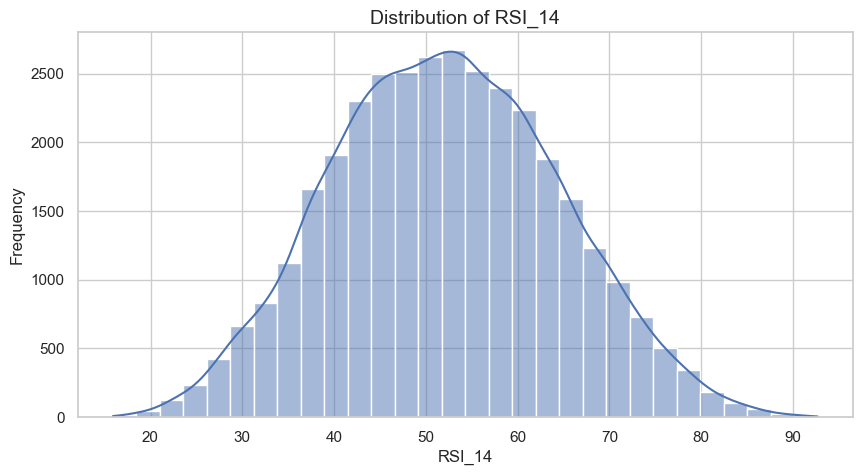

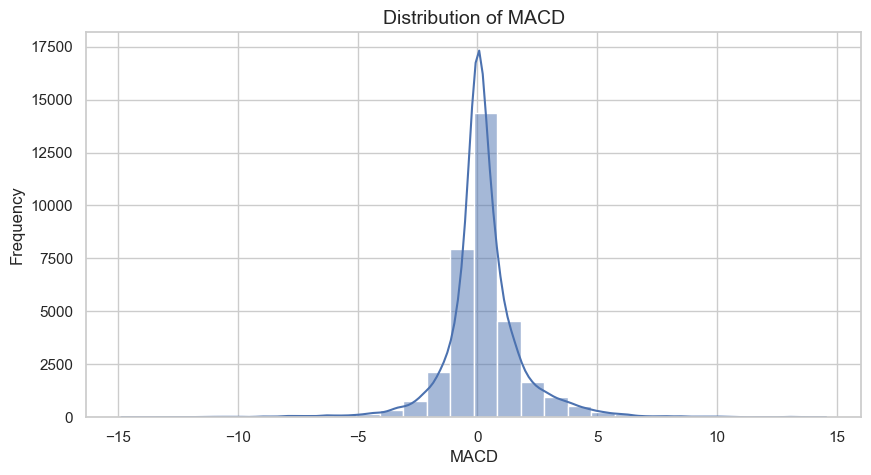

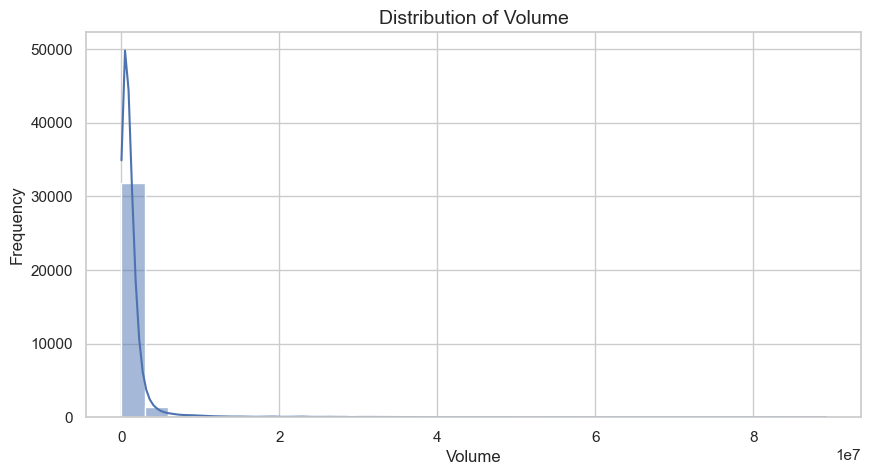

In [10]:
features = ['RSI_14', 'MACD', 'Volume']

for feature in features:
    plt.figure(figsize=(10, 5))
    
    sns.histplot(mcs_df[feature], kde=True, bins=30)
    
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#### 4) Generate a Correlation Heatmap to Spot Redundant Features
Highly correlated features can be redundant and may hurt certain models. Use a heatmap to visually inspect correlation between numerical features.
- **Resource**: [5 Minute EDA: Correlation Heatmap](https://medium.com/5-minute-eda/5-minute-eda-correlation-heatmap-b57bbb7bae14)

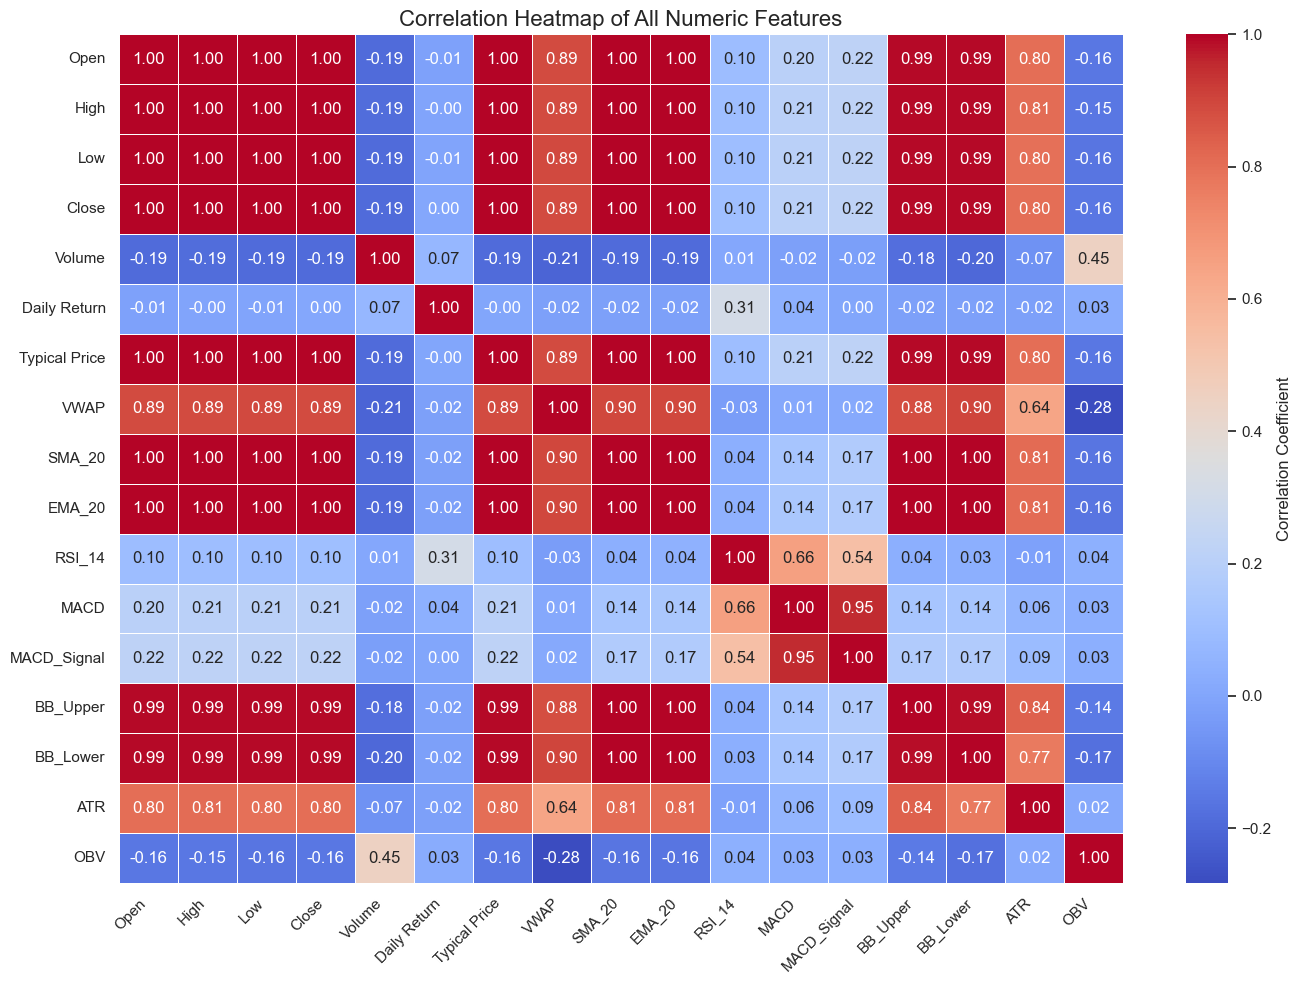

In [11]:
corr_matrix = mcs_df.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, 
            cmap='coolwarm', 
            annot=True,
            fmt=".2f", 
            linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title("Correlation Heatmap of All Numeric Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

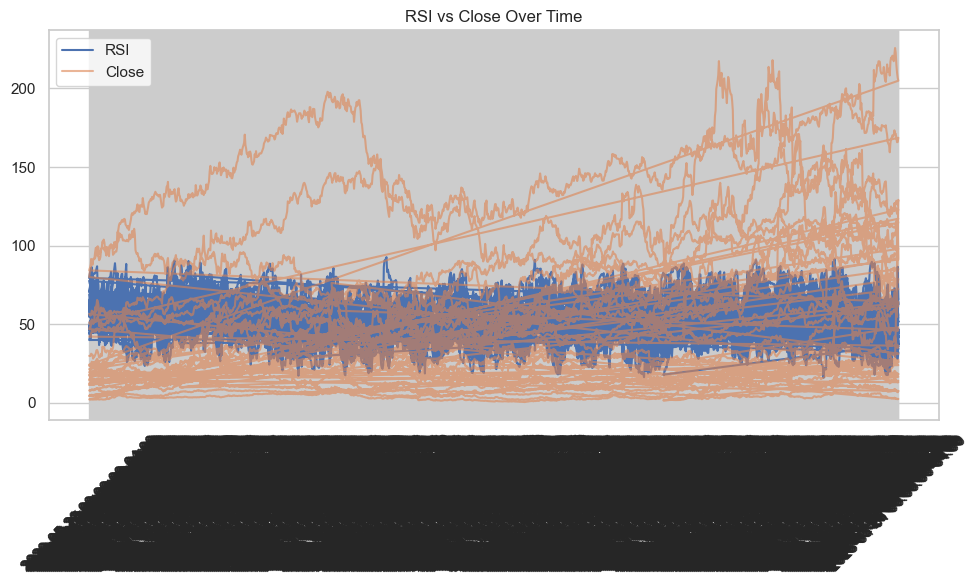

In [17]:
#How does RSI, MACD, or ATR behave before big price movements?
plt.plot(mcs_df['Date'], mcs_df['RSI_14'], label='RSI')
plt.plot(mcs_df['Date'], mcs_df['Close'], label='Close', alpha=0.6)
plt.legend()
plt.title("RSI vs Close Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 5) Check the Relationship Between Features and the Target
Explore how technical indicators relate to the target (next day’s close). Use scatter plots or group-by summaries to spot patterns.
- **Resource**: [Scatter plot with a grouping variable with Pandas](https://python-graph-gallery.com/537-scatter-plots-grouped-by-color-with-pandas/)

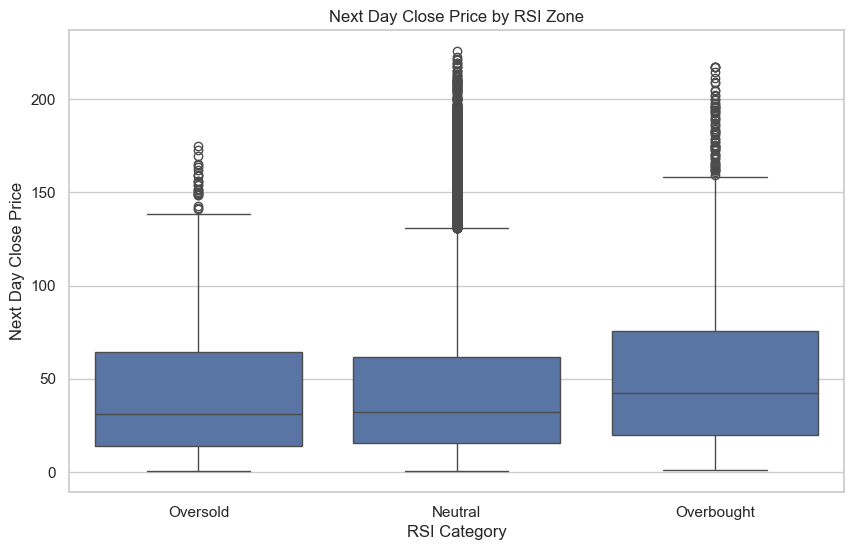

In [12]:
#Create the target variable (next day's Close)
mcs_df['Target'] = mcs_df['Close'].shift(-1)

# Create RSI category bins
mcs_df['RSI_Binned'] = pd.cut(
    mcs_df['RSI_14'], 
    bins=[0, 30, 70, 100], 
    labels=['Oversold', 'Neutral', 'Overbought']
)

sns.boxplot(x='RSI_Binned', y='Target', data=mcs_df)
plt.title("Next Day Close Price by RSI Zone")
plt.xlabel("RSI Category")
plt.ylabel("Next Day Close Price")
plt.show()


#### 6) Use Boxplots to Detect Outliers
- Boxplots are a great way to spot extreme values or outliers in numeric features. 
- Outliers can influence your model heavily — decide whether to keep, remove, or transform them.
- **Resource**: [How to detect outliers using IQR and Boxplots?](https://www.machinelearningplus.com/machine-learning/how-to-detect-outliers-using-iqr-and-boxplots/)

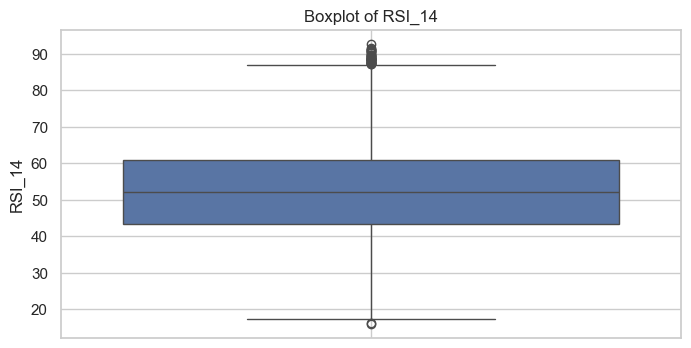

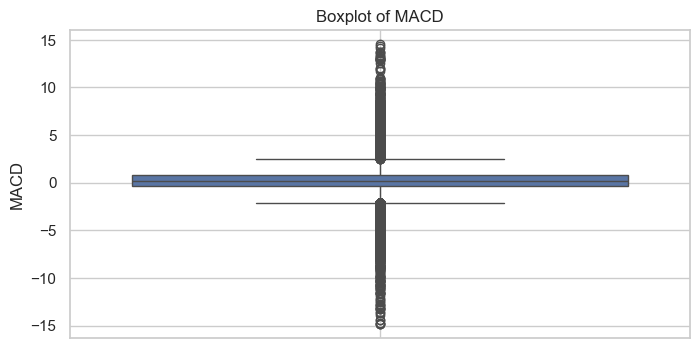

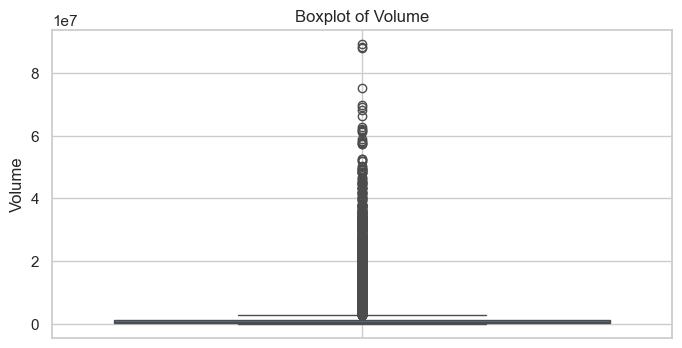

In [14]:
features_to_plot = ['RSI_14', 'MACD', 'Volume']

# Loop through each feature and plot a boxplot
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(y=mcs_df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.grid(True)
    plt.show()

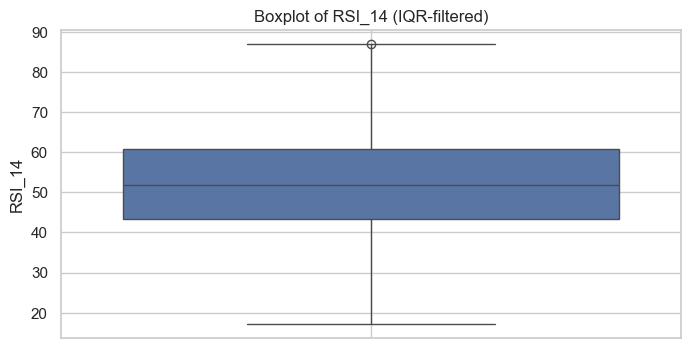

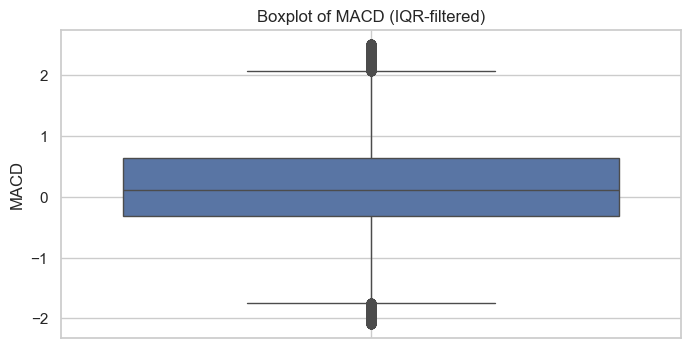

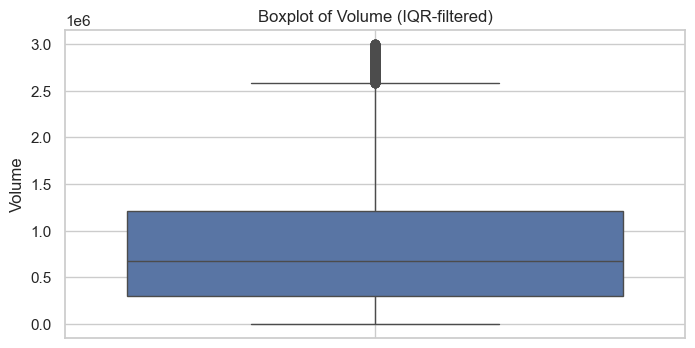

In [18]:
# Loop through each feature, filter using IQR, then plot
for feature in features_to_plot:
    Q1 = mcs_df[feature].quantile(0.25)
    Q3 = mcs_df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # IQR filtering: keep only data within bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = mcs_df[(mcs_df[feature] >= lower_bound) & (mcs_df[feature] <= upper_bound)]

    # Plot boxplot of filtered data
    plt.figure(figsize=(8, 4))
    sns.boxplot(y=filtered_df[feature])
    plt.title(f'Boxplot of {feature} (IQR-filtered)')
    plt.grid(True)
    plt.show()


#### 7) Investigate Patterns Over Time or Between Groups (Sector, Ticker, etc.)
- Use time-based plots to see if the target or indicators change by day of the week or over time.
- Grouped boxplots can help reveal differences between companies or sectors.
- **Resource**: [Python Plotting for Exploratory Data Analysis](https://pythonplot.com/)

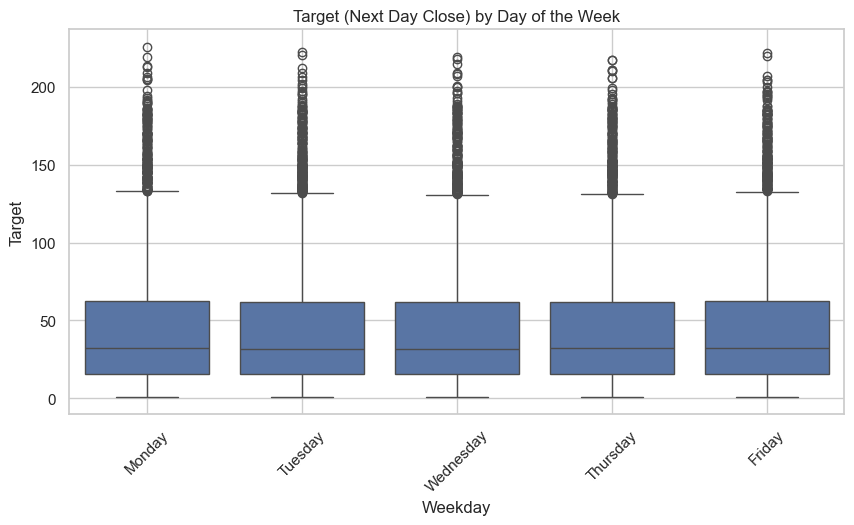

In [22]:
# Convert 'Date' to datetime safely since it's originally an object
mcs_df['Date'] = pd.to_datetime(mcs_df['Date'], errors='coerce')

# Drop any rows where 'Date' couldn't be converted
mcs_df = mcs_df.dropna(subset=['Date'])

# Extract the weekday
mcs_df['Weekday'] = mcs_df['Date'].dt.day_name()

plt.figure(figsize=(10, 5))
sns.boxplot(x='Weekday', y='Target', data=mcs_df, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.title("Target (Next Day Close) by Day of the Week")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


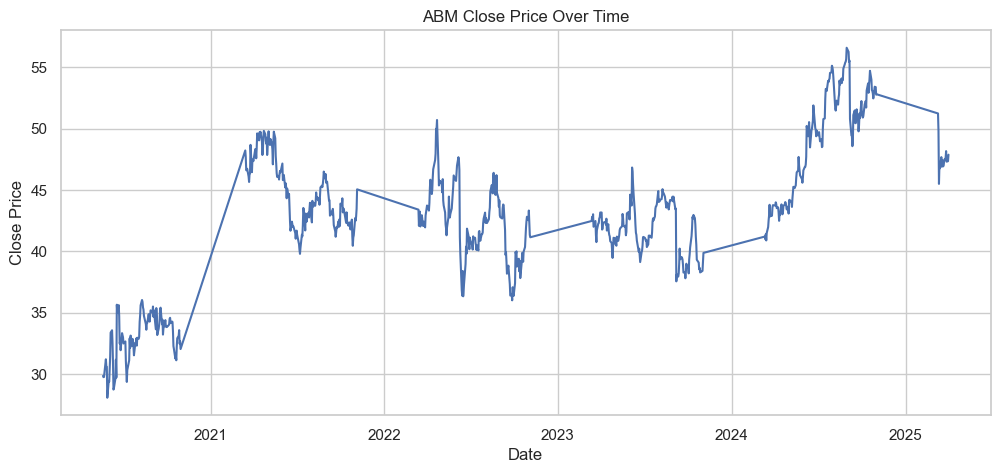

In [23]:
single_ticker_df = mcs_df[mcs_df['Ticker'] == 'ABM']

plt.figure(figsize=(12, 5))
sns.lineplot(data=single_ticker_df, x='Date', y='Close')
plt.title("ABM Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

#### 8) Brainstorm & Engineer New Features Based on Your Insights
- Consider creating features like price range, volatility, lagged prices, or differences from moving averages.
- These can help capture patterns not directly visible in raw features.
- **Resource**: [A Reference Guide to Feature Engineering](https://www.kaggle.com/code/prashant111/a-reference-guide-to-feature-engineering-methods)